# DS-GA 3001.001 Special Topics in Data Science: Probabilistic Time Series Analysis

# Week 4 EM

In [228]:
# Install PyKalman
# pip install pykalman
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy.stats import multivariate_normal

# Data Visualiztion
def plot_kalman(x,y,nx,ny,kx=None,ky=None, plot_type="r-", label=None, title='Parabola'):
    """
    Plot the trajectory
    """
    fig, ax = plt.subplots(1,2, figsize=(15,4))
    if kx is not None and ky is not None:
        ax[0].plot(x,y,'g-',nx,ny,'b.',kx,ky, plot_type)
        ax[0].plot(kx[0], ky[0], 'or')
        ax[0].plot(kx[-1], ky[-1], 'xr')
        
        ax[1].plot(x, kx, '.k', label='latent dim 1')
        ax[1].plot(y, ky, '.', color='grey', label='latent dim 2')
        ax[1].set_xlabel('real latent')
        ax[1].set_ylabel('estimated latent')
        ax[1].legend()
    else:
        ax[0].plot(x,y,'g-',nx,ny,'b.')
        
        ax[1].plot(x, nx, '.k', label='dim 1')
        ax[1].plot(y, ny, '.', color='grey', label='dim 2')
        ax[1].set_xlabel('latent')
        ax[1].set_ylabel('observed')
        ax[1].legend()

    ax[0].set_xlabel('X position')
    ax[0].set_ylabel('Y position')
    ax[0].set_title(title)
    ax[0].set_aspect(1)
    ax[1].set_aspect(1)
    
    if kx is not None and ky is not None and label is not None:
        ax[0].legend(('true','measured', label))
    else:
        ax[0].legend(('true','measured'))
    
    return fig
    
def visualize_line_plot(data, xlabel, ylabel, title):
    """
    Function that visualizes a line plot
    """
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
def print_parameters(kf_model, need_params=None, evals=False):
    """
    Function that prints out the parameters for a Kalman Filter
    @param - kf_model : the model object
    @param - need_params : a list of string
    """
    if evals:
        if need_params is None:
            need_params1 = ['transition_matrices', 'transition_covariance','observation_matrices', 'observation_covariance','initial_state_mean', 'initial_state_covariance']
            need_params2 = [ 'initial_state_mean', 'initial_state_covariance']
        #for param in need_params1: 
        #    tmp = np.linalg.eig(getattr(kf_model, param))[0]
        #    print("{0} = {1}, shape = {2}\n".format(param, tmp, tmp.shape))
            #print("{0} = {1}, shape = {2}\n".format(param, tmp, [2,2]))
        for param in need_params1: 
            print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))
            
    else:
        if need_params is None:
            need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance', 'observation_covariance', 
                            'initial_state_mean', 'initial_state_covariance']
        for param in need_params: 
            print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))
    

In [ ]:
!pip install pykalman

## Kalman

We want to infer the latent variable $z_n$ given the observed variable $x_n$.

$$P(z_n|x_1, ..., x_n, x_{n+1}, ..., x_N)\sim N(\hat{\mu_n}, \hat{V_n})$$

### Forward: Filtering
obtain estimates of latent by running the filtering from $n=0,....N$ 

#### prediction given latent space parameters
<br>
<img src='img/LDS_latent.svg', width = 110, height=90>


$$z_n^{pred}\sim N(\mu_n^{pred},V_n^{pred})$$

$$\mu_n^{pred}=A\mu_{n-1}$$

*this is the prediction for $z_n$ obtained simply by taking the expected value of $z_{n-1}$ and projecting it forward one step using the transition probability matrix $A$*

$$V_n^{pred}=AV_{n-1}A^T+\Gamma$$
*same for the covariance taking into account the noise covariance $\Gamma$*

#### correction (innovation) from observation
<br>
<img src='img/LDS_observed.svg', width = 40, height=80>

project to observational space:
$$x_n^{pred}\sim N(C\mu_n^{pred}, CV_n^{pred}C^T+\Sigma)$$

correct prediction by actual data:
$$z_n^{innov}\sim N(\mu_n^{innov}, V_n^{innov})$$

$$\mu_n^{innov}=\mu_n^{pred}+K_n(x_n-C\mu_n^{pred})$$

$$V_n^{innov}=(I-K_nC)V_n^{pred}$$

Kalman gain matrix: 
$$K_n=V_n^{pred}C^T(CV_n^{pred}C^T+\Sigma)^{-1}$$

*we use the latent-only prediction to project it to the observational space and compute a correction proportional to the error $x_n-CAz_{n-1}$ between prediction and data, coefficient of this correction is the Kalman gain matrix*

<br>
<img src='img/Kfilter_Bishop.png', width = 600, height=600>
from Bishop (2006), chapter 13.3

*if measurement noise is small and dynamics are fast -> estimation will depend mostly on observed data*

### Backward: Smoothing

<br>
<img src='img/LDS_smooth.svg', width = 110, height=100>

obtain estimates by propagating from $x_n$ back to $x_1$ using results of forward pass ($\mu_n^{innov}, V_n^{innov}, V_n^{pred}$)


$$N(z_n|\mu_n^{smooth}, V_n^{smooth})$$

$$\mu_n^{smooth}=\mu_n^{innov}+J_n(\mu_{n+1}^{smooth}-A\mu_n^{innov})$$

$$V_n^{smooth}=V_n^{innov}+J_n(V_{n+1}^{smooth}-V_{n+1}^{pred})J_n^T$$

$$J_N=V_n^{innov}A^T (V_{n+1}^{pred})^{-1}$$

This gives us the final estimate for $z_n$.

$$\hat{\mu_n}=\mu_n^{smooth}$$
$$\hat{V_n}=V_n^{smooth}$$

## EM algorithm

- want to maximize $log p(x|\theta)$

- need to marginalize out latent *(which is not tractable)*

$$log \left(p(x|\theta)\right)=log \left(\int p(x,z|\theta)dz\right)$$

- add a probability distribution $q(z)$ which will approximate the latent distribution 

$$=\int_z q(z) log p(x|\theta) dz$$

- can be rewritten as

$$=\mathcal{L}(q,\theta)+KL\left(q(z)||p(z|x),\theta\right)$$

- $\mathcal{L}(q,\theta)$ contains the joint distribution of $x$ and $z$

- $KL(q||p)$ contains the conditional distribution of $z|x$

#### Expectation step
- parameters are kept fixed
- find a good approximation $q(z)$: maximize lower bound $\mathcal{L}(q,\theta)$ with respect to $q(z)$
- (already implemented Kalman filter+smoother)

#### Maximization step
- keep distribution $q(z)$ fixed
- change parameters to maximize the lower bound $\mathcal{L}(q,\theta)$


### M-step
*(see Bishop, chapter 13.3.2 Learning in LDS)*

Update parameters of the probability distribution

Initial parameters
$$\mu_0^{new}=E(z_1)$$
$$\Gamma_0^{new} = E(z_1z_1^T)-E(z_1)E(z_1^T)$$

Latent parameters
$$A^{new} = \left(\sum_{n=2}^N E(z_nz_{n-1}^T)\right)\left(\sum_{n=2}^N E(z_{n-1}z_{n-1}^T)\right)^{-1}$$
$$\Gamma^{new} = \frac{1}{N-1}\sum_{n=2}^N E(z_nz_n^T)-A^{new}E(z_{n-1}z_{n}^T)-E(z_nz_{n-1}^T)A^{new}+A^{new}E(z_{n-1}z_{n-1}^T)(A^{new})^{T}$$

Observable space parameters
$$C^{new}=\left(\sum_{n=1}^N x_n E(z_n^T)\right)\left(\sum_{n=1}^N E(z_n z_n^T)\right)^{-1}$$
$$\Sigma^{new}=\frac{1}{N}\sum_{n=1}^Nx_nx_n^T-C^{new}E(z_n)x_n^T-x_nE(z_n^T)C^{new}+C^{new}E(z_nz_n^T)C_{new}$$

*For the updates in the M-step we will need the following posterior marginals obtained from the Kalman smoothing results* $\hat{\mu}_n, \hat{V}_n$

$$E(z_n)=\hat{\mu}_n$$
$$E(z_nz_{n-1}^T)=J_{n-1}\hat{V}_n+\hat{\mu}_n\hat{\mu}_{n-1}^T$$
$$E(z_nz_{n}^T)=\hat{V}_n+\hat{\mu}_n\hat{\mu}_{n}^T$$

# Kalman + EM Implementation

In this part of the exercise, you will implement the EM algorithm, building up on the exercises from last week. 

In [230]:
class MyKalmanFilter:
    """
    Class that implements the Kalman Filter
    """
    def __init__(self, n_dim_state=2, n_dim_obs=2):
        """
        @param n_dim_state: dimension of the laten variables
        @param n_dim_obs: dimension of the observed variables
        """
        self.n_dim_state = n_dim_state
        self.n_dim_obs = n_dim_obs
        self.transition_matrices = np.eye(n_dim_state)
        self.transition_covariance = np.eye(n_dim_state)
        self.observation_matrices = np.eye(n_dim_obs, n_dim_state)
        self.observation_covariance = np.eye(n_dim_obs)
        self.initial_state_mean = np.zeros(n_dim_state)
        self.initial_state_covariance = np.eye(n_dim_state)
        self.J_n_list = []
        
    def sample(self, n_timesteps, initial_state=None, random_seed=None):
        """
        Method that gives samples
        @param initial_state: numpy array whose length == self.n_dim_state
        @param random_seed: an integer, for test purpose
        @output state: a 2d numpy array with dimension [n_timesteps, self.n_dim_state]
        @output observation: a 2d numpy array with dimension [n_timesteps, self.n_dim_obs]
        """
        
        latent_state = np.zeros([n_timesteps, self.n_dim_state])
        observed_state = np.zeros([n_timesteps, self.n_dim_obs])
        
        if random_seed is not None:
            np.random.seed(random_seed)
        
        ################
        ##### TODO #####
        ################

        # produce samples
        z_n = [] # latent vectors, 
        x_n = [] # observation vectors
        # set initial states for latent vector, z_0
        if initial_state is None:
          z_n.append(self.initial_state_mean)
        else:
          z_n.append(initial_state)
        x_n.append(self.observation_matrices.dot(z_n[0]) + np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))
        for t in range(1,n_timesteps):
          # sampel z_n and multiply with transition matrice, A and get z_t = A* z_t-1 + gamma
          z_n.append(self.transition_matrices.dot(z_n[t-1]) + np.random.multivariate_normal(np.zeros(self.n_dim_state), self.transition_covariance))
          # compute x_t corresponding to z_t, x_t = C*z_t + sigma
          x_n.append(self.observation_matrices.dot(z_n[t]) + np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))
        return np.array(z_n), np.array(x_n)
        
        return latent_state, observed_state
    
        
    def filter(self, X):
        """
        Method that performs Kalman filtering
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: filtered_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: filtered_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """
        
        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim==self.n_dim_obs
        
        # create holders for outputs
        filtered_state_means = np.zeros( (n_example, self.n_dim_state) )
        filtered_state_covariances = np.zeros( (n_example, self.n_dim_state, self.n_dim_state) )
        
        #############################
        # TODO: implement filtering #
        #############################
        # mu0 and sigam0
        filtered_state_means[0] = self.initial_state_mean
        filtered_state_covariances[0] = self.initial_state_covariance
        # initialize internal variables
        mu_n_1 = self.initial_state_mean.copy()
        V_n_1 = self.initial_state_covariance.copy()

        for j in np.arange(1, n_example):
          
          A = self.transition_matrices
          C = self.observation_matrices

          # predict mean and covariance of latent varialbes, z_n,  with current mean and covariance matrices         
          mu_pred = A.dot(mu_n_1)
          V_n_pred = A.dot(V_n_1).dot(A.T) + self.transition_covariance # V_n_pred = A*V_n_1*A' + gammma
          # observe the variables,  x_n, with current mu and covariance matrix
          x_n = X[j,:] 
          mu_n_obs = C.dot(mu_pred) # mu_n_obs = C*mu_n
          cov_n_obs = C.dot(V_n_pred).dot(C.T) + self.observation_covariance # C_obj = C*V_n*C' + SIGMA

          # compute kalman gain
          kalman_gain = V_n_pred.dot(C.T).dot(np.linalg.inv(cov_n_obs)) # V_n*C' * C_obj^(-1)

          # compute updated covariance, V_n_update, and mean, mu_n_update
          I = np.eye(V_n_1.shape[0]) # new covariance has the same size as previous one
          V_n_update = (I-kalman_gain.dot(C)).dot(V_n_pred)
          mu_n_update = mu_pred + kalman_gain.dot(x_n-mu_n_obs)
        
          # save the mu_n and V_n
          filtered_state_means[j,:] = mu_n_update
          filtered_state_covariances[j,:,:]= V_n_update
          # update the previous mean and covariance matrices
          mu_n_1 = mu_n_update
          V_n_1 = V_n_update

        return filtered_state_means, filtered_state_covariances
  
    def smooth(self, X):
        """
        Method that performs the Kalman Smoothing
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: smoothed_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: smoothed_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """
        # TODO: implement smoothing
        
        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim==self.n_dim_obs
        
        # run the forward path
        mu_list, v_list = self.filter(X)
        
        # create holders for outputs
        smoothed_state_means = np.zeros( (n_example, self.n_dim_state) )
        smoothed_state_covariances = np.zeros( (n_example, self.n_dim_state, self.n_dim_state) )
        
        #############################
        # TODO: implement smoothing #
        #############################
        # initialize mean and covariance to propagat it back
        smoothed_state_means[-1, :] = mu_list[-1, :]
        smoothed_state_covariances[-1, :, :] = v_list[-1, :, :]
        A = self.transition_matrices # transition matrix
        N = n_example
        J_n_list = []
        for j in range(2, N+1):
          V_innov_n = v_list[N-j,:,:]
          
          V_pred_n_1 = A.dot(V_innov_n).dot(A.T) + self.transition_covariance # V_n_1 = A*V_n*A' + sigma
  
          J_n = V_innov_n.dot(A.T).dot(np.linalg.inv(V_pred_n_1))
          
          mu_innov_n = mu_list[N-j,:]
          mu_smooth_n_1 = smoothed_state_means[N-j+1,:]
          V_smooth_n_1 = smoothed_state_covariances[N-j+1,:,:]

          smoothed_mean = mu_innov_n + J_n.dot(mu_smooth_n_1 - A.dot(mu_innov_n))
          smoothed_cov = V_innov_n + J_n.dot(V_smooth_n_1 - V_pred_n_1).dot(J_n.T)
     
          smoothed_state_means[N-j, :] = smoothed_mean
          smoothed_state_covariances[N-j, :, :] = smoothed_cov
          J_n_list.append(J_n)

        # compute final prediction and J_n
        V_n = v_list[-1,:,:]
        V_pred_n = A.dot(V_n).dot(A.T) + self.transition_covariance
        J_n = V_n.dot(A.T).dot(np.linalg.inv(V_pred_n))
        J_n_list.append(J_n) # append n'th J_n
        self.J_n_list = J_n_list

        return smoothed_state_means, smoothed_state_covariances

    
    def em(self, X, max_iter=10):
        """
        Method that perform the EM algorithm to update the model parameters
        Note that in this exercise we ignore offsets
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @param max_iter: an integer indicating how many iterations to run
        """
        # validate inputs have right dimensions
        n_example, observed_dim = X.shape
        assert observed_dim==self.n_dim_obs
        
        # keep track of log posterior (use function calculate_posterior below)
        self.avg_em_log_posterior = np.zeros(max_iter)*np.nan
        
        #############################
        #### TODO: EM iterations ####
        #############################
        for i in np.arange(max_iter):
          # E-step
          mu_n, V_n = self.smooth(X)
          self.initial_state_mean = mu_n[0,:] # save the initial mean and variance 
          self.initial_state_covariance = V_n[0,:]
          
          log_P_x_n = self.calculate_posterior(X, mu_n) # compute the posterior pdf of X_n
          log_P_x_n = np.nanmean(log_P_x_n)
          self.avg_em_log_posterior[i] = log_P_x_n
          #define E[Z_n], E[Z_n Z_n-1], E[z_nz_n]
          self.E_z_n =  np.array(mu_n)
          self.E_z_n_z_n_1 = []
          self.E_z_n_z_n = []

          for ii in np.arange(n_example):
            mu_i = mu_n [ii,:] 
            if ii>0:
              mu_i_1 = mu_n[ii-1, :]
              self.E_z_n_z_n_1.append(self.J_n_list[ii-1].dot(V_n[ii]) +mu_i[None].T.dot(mu_i_1[None])) # J_n-1 *V_n + mu_n*mu_n-1'
            self.E_z_n_z_n.append(V_n[ii] + mu_i[None].T.dot(mu_i[None])) # V_n + mu_n*mu_n'

          # M - step
          sum_E_z_n_z_n = np.array(self.E_z_n_z_n).sum(0) # this icludes all the example from 1 to N
          sum_E_z_n_z_n_noN = np.array(self.E_z_n_z_n[:-1]).sum(0) # includes the examples from 1 to N-1
          sum_E_z_n_z_n_no1 = np.array(self.E_z_n_z_n[1:]).sum(0) # includes the examples from 1 to N-1

          sum_E_z_n_z_n_1 = np.array(self.E_z_n_z_n_1).sum(0)

          # compute new transition matrix, A_new = sum(E_zn_zn-1')* sum(E_zn-1_zn-1')^(-1)
          self.transition_matrices = sum_E_z_n_z_n_1.dot(np.linalg.inv(sum_E_z_n_z_n_noN))
          # compute new covariance matrix, gamma_new, which is given in handout
          self.transition_covariance = (sum_E_z_n_z_n_no1 - sum_E_z_n_z_n_1.dot(self.transition_matrices.T) 
          - self.transition_matrices.dot(sum_E_z_n_z_n_1.T) + self.transition_matrices.dot(sum_E_z_n_z_n_noN).dot(self.transition_matrices.T))/(n_example-1)

          # update  observation matrix, C 
          # sum (x_n *z_n') = X.T Z_n in matrix form
          self.observation_matrices = X.T.dot(self.E_z_n).dot(np.linalg.inv(sum_E_z_n_z_n.T))
          # update observation covariance matrix, Sigma
          for t in range(n_example):
            dif = X[t] - self.observation_matrices.dot(mu_n[t])  
            self.observation_covariance += dif[None].T.dot(dif[None]) + self.observation_matrices.dot(V_n[t]).dot(self.observation_matrices.T)
          
          self.observation_covariance /= n_example


    def import_param(self, kf_model):
        """
        Method that copies parameters from a trained Kalman Model
        @param kf_model: a Pykalman object
        """
        need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance', 
                  'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
        for param in need_params:
            setattr(self, param, getattr(kf_model, param))
            
            
    def calculate_posterior(self, X, state_mean, v_n=None):
        """
        Method that calculates the log posterior
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @param state_mean: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: a numpy 1D array whose dimension is [n_example]
        """
        
        if v_n is None:
            _, v_n = self.filter(X)
        llh = []
        for i in range(1,len(state_mean)):
            normal_mean = np.dot(self.observation_matrices, np.dot(self.transition_matrices, state_mean[i-1]))
            p_n = self.transition_matrices.dot(v_n[i].dot(self.transition_matrices))+self.transition_covariance
            #normal_cov = np.matmul(self.observation_matrices, np.matmul(self.p_n_list[i], self.observation_matrices.T)) + self.observation_covariance
            normal_cov = np.matmul(self.observation_matrices, np.matmul(p_n, self.observation_matrices.T)) + self.observation_covariance
            #print (self.observation_covariance)
            pdf_val = multivariate_normal.pdf(X[i], normal_mean, normal_cov)
            # replace 0 to prevent numerical underflow
            if pdf_val < 1e-10:
                pdf_val = 1e-10
            llh.append(np.log(pdf_val))            
        return np.array(llh)
        

## Sampling

In [231]:
# Sampling
n_dim_state = 2
n_dim_obs = 2
kf = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
# set paramters
kf.transition_matrices = np.eye(kf.n_dim_state)*.5
kf.transition_covariance = np.eye(kf.n_dim_obs)
kf.observation_matrices = np.eye(kf.n_dim_state)
kf.observation_covariance = np.eye(kf.n_dim_obs)*.1
kf.initial_state_mean = np.zeros(kf.n_dim_state)
kf.initial_state_covariance = np.eye(kf.n_dim_state)*.1
# import to your own kalman object
my_kf = MyKalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
my_kf.import_param(kf)
# print the parameters
print_parameters(my_kf, evals=True)

transition_matrices = [[0.5 0. ]
 [0.  0.5]], shape = (2, 2)

transition_covariance = [[1. 0.]
 [0. 1.]], shape = (2, 2)

observation_matrices = [[1. 0.]
 [0. 1.]], shape = (2, 2)

observation_covariance = [[0.1 0. ]
 [0.  0.1]], shape = (2, 2)

initial_state_mean = [0. 0.], shape = (2,)

initial_state_covariance = [[0.1 0. ]
 [0.  0.1]], shape = (2, 2)



### test that your sampling works:

sampled states pykalman at t=2:  [1.43945741 0.96908939]
sampled states own implementation at t=2:  [1.43945741 0.96908939]


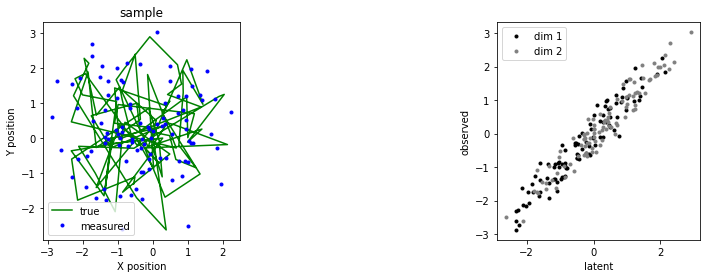

In [232]:
sampled_states, sampled_observations = kf.sample(100, initial_state=kf.initial_state_mean, random_state=np.random.RandomState(0))
sampled_states_impl, sampled_observations_impl = my_kf.sample(100, initial_state=kf.initial_state_mean, random_seed=0)
print('sampled states pykalman at t=2: ', sampled_states[2,:])
print('sampled states own implementation at t=2: ', sampled_states_impl[2,:])
fig = plot_kalman(sampled_states_impl[:,0],sampled_states_impl[:,1],sampled_observations_impl[:,0],sampled_observations_impl[:,1], title='sample');


### reduce observation noise
What do you expect should happen?

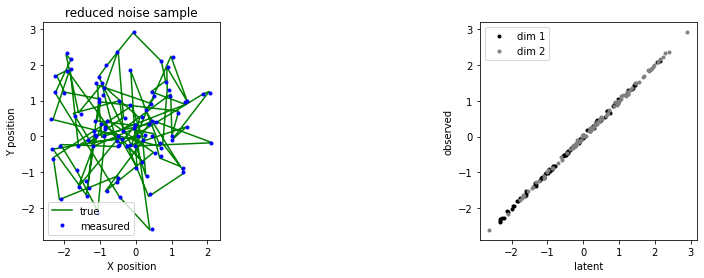

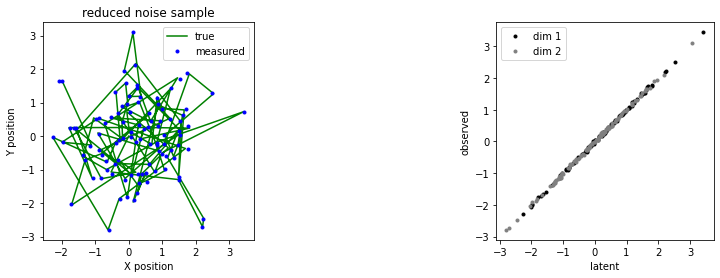

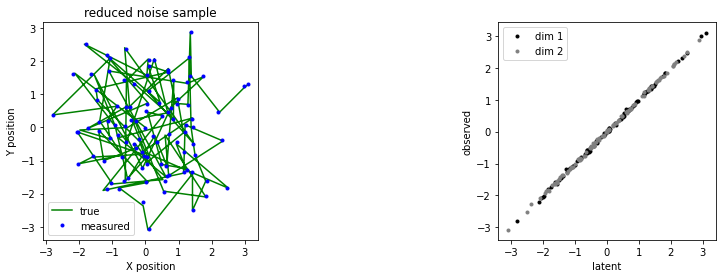

In [233]:
#### TODO ####
#### reduce observation noise ####
obscov_old = my_kf.observation_covariance.copy()
my_kf.observation_covariance = my_kf.observation_covariance*.01

# plot
for nn in range(3):
    sampled_states_impl, sampled_observations_impl = my_kf.sample(100, initial_state=kf.initial_state_mean, random_seed=nn)
    fig = plot_kalman(sampled_states_impl[:,0],sampled_states_impl[:,1],sampled_observations_impl[:,0],sampled_observations_impl[:,1], title='reduced noise sample');
    plt.axis('square');

### increase the respective temporal dyamics
What do you expect should happen?

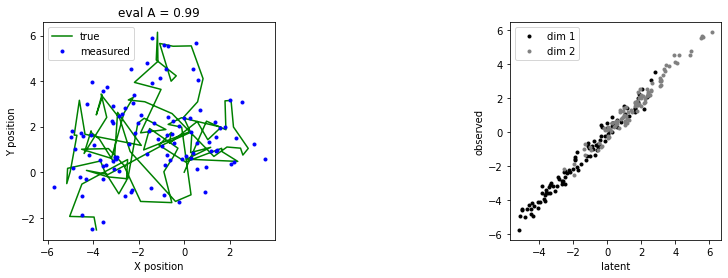

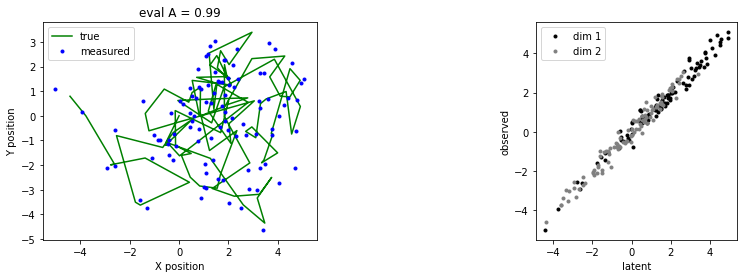

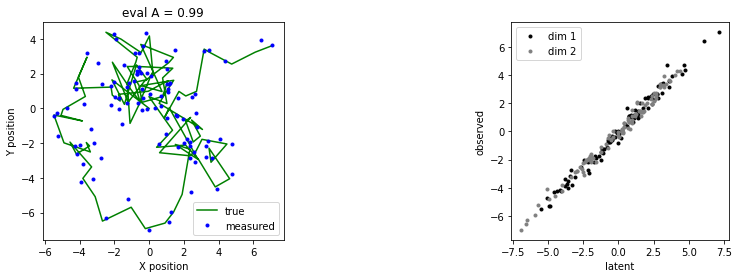

In [ ]:
#### TODO ####
#### increase latent temporal dependency ####
my_kf.observation_covariance = obscov_old.copy()
my_kf.transition_matrices = np.eye(n_dim_state)*.9

# plot
for nn in range(3):
    sampled_states_impl, sampled_observations_impl = my_kf.sample(100, initial_state=kf.initial_state_mean, random_seed=nn)
    fig = plot_kalman(sampled_states_impl[:,0],sampled_states_impl[:,1],
                      sampled_observations_impl[:,0],sampled_observations_impl[:,1], title='eval A = '+np.str(.99));

# EM

### data to use

transition_matrices = [[0.9 0. ]
 [0.  0.9]], shape = (2, 2)

transition_covariance = [[1. 0.]
 [0. 1.]], shape = (2, 2)

observation_matrices = [[1. 0.]
 [0. 1.]], shape = (2, 2)

observation_covariance = [[1. 0.]
 [0. 1.]], shape = (2, 2)

initial_state_mean = [0. 0.], shape = (2,)

initial_state_covariance = [[0.1 0. ]
 [0.  0.1]], shape = (2, 2)



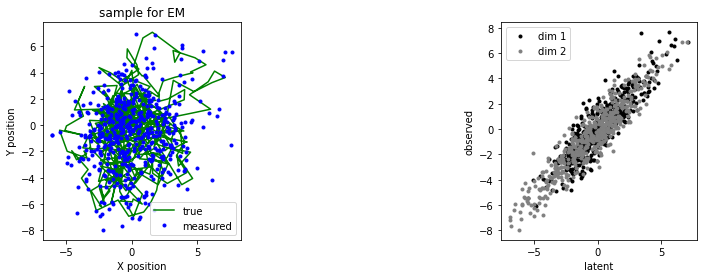

In [ ]:
kf_GT = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
# set paramters
kf_GT.transition_matrices = np.eye(n_dim_state)*.9
kf_GT.transition_covariance = np.eye(n_dim_obs)
kf_GT.observation_matrices = np.eye(n_dim_state)
kf_GT.observation_covariance = np.eye(n_dim_obs)
kf_GT.initial_state_mean = np.zeros(n_dim_state)
kf_GT.initial_state_covariance = np.eye(n_dim_state)*.1
# import to your own kalman object
my_kf_GT = MyKalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
my_kf_GT.import_param(kf_GT)
# print the parameters
print_parameters(my_kf_GT, evals=True)


# sample
latent, data = kf_GT.sample(500, initial_state=kf_GT.initial_state_mean, random_state=np.random.RandomState(2))
_, _ = kf_GT.filter(data)
estlat,_ = kf_GT.smooth(data)
fig = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], title='sample for EM');


### Filtering
with known parameters

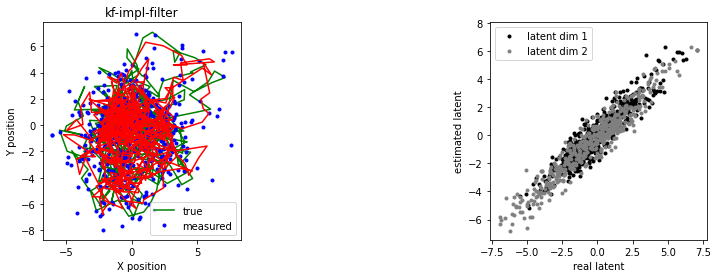

In [ ]:
filtered_state_means_impl, filtered_state_covariances_impl = my_kf_GT.filter(data)
fig = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], filtered_state_means_impl[:,0], filtered_state_means_impl[:,1], "r-", title ="kf-impl-filter")
plt.axis('square');

### Smoothing
with known parameters

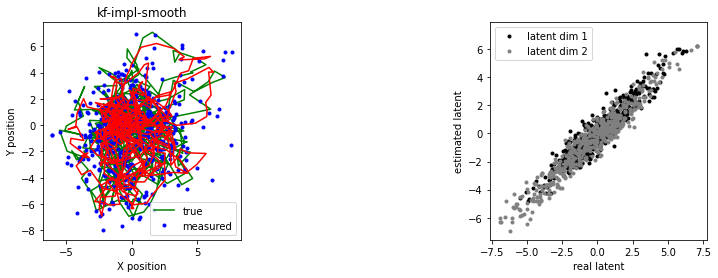

In [ ]:
smoothed_state_means_impl, smoothed_state_covariances_impl = my_kf_GT.smooth(data)
fig = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], 
                  smoothed_state_means_impl[:,0], smoothed_state_means_impl[:,1], "r-", title="kf-impl-smooth")
plt.axis('square');

### run EM
to learn parameters (M-step)

In [234]:
np.random.seed(0)

iters = 10
# perturb starting parameters
kf = KalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1],
                 transition_matrices= np.eye(data.shape[1]) * 0.95,
                 observation_matrices= np.eye(data.shape[1])+np.random.randn(data.shape[1])*.1,
                 transition_covariance= np.eye(data.shape[1]),
                 observation_covariance = np.eye(data.shape[1]),
                 initial_state_mean=np.random.randn(data.shape[1]),
                  initial_state_covariance = np.eye(data.shape[1]),
                 em_vars = ['transition_matrices', 'observation_matrices','transition_covariance','observation_covariance',
                          'initial_state_mean', 'initial_state_covariance'])

my_kf = MyKalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1])
my_kf.import_param(kf)

kf.em(data, n_iter=iters)
my_kf.em(data, max_iter=iters)

print('           pykalman EM:')
print(' ')
print_parameters(kf, evals=True)
print('           own implementation EM:')
print(' ')
print_parameters(my_kf, evals=True)

           pykalman EM:
 
transition_matrices = [[0.88225902 0.00495049]
 [0.0436223  0.92445577]], shape = (2, 2)

transition_covariance = [[ 0.7611354  -0.11513894]
 [-0.11513894  0.87116829]], shape = (2, 2)

observation_matrices = [[1.12314164 0.02460226]
 [0.1431459  1.01994597]], shape = (2, 2)

observation_covariance = [[0.97784395 0.00733072]
 [0.00733072 0.89030881]], shape = (2, 2)

initial_state_mean = [-1.20813372  0.51062271], shape = (2,)

initial_state_covariance = [[ 0.04929074 -0.0087749 ]
 [-0.0087749   0.05566642]], shape = (2, 2)

           own implementation EM:
 
transition_matrices = [[0.8852786  0.00456105]
 [0.04038545 0.92564147]], shape = (2, 2)

transition_covariance = [[ 0.75757793 -0.11581952]
 [-0.11581952  0.87202866]], shape = (2, 2)

observation_matrices = [[1.0973071046514233 0.031644823123031914]
 [0.1561404353738916 1.0131740707718653]], shape = (2, 2)

observation_covariance = [[ 1.02518673 -0.00931103]
 [-0.00931103  0.9055051 ]], shape = (2, 2)


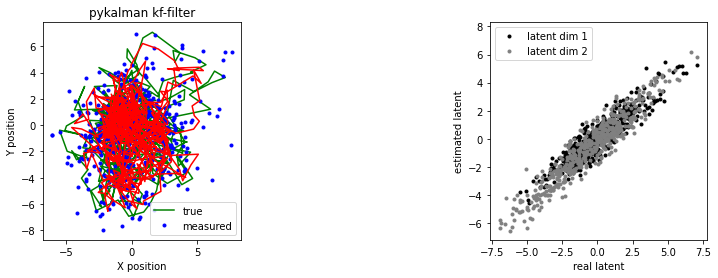

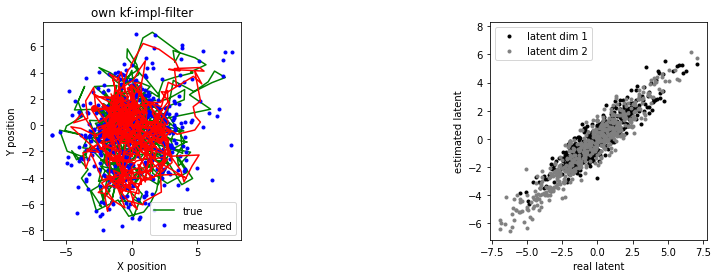

In [235]:
# compare the filter results
filtered_state_means, filtered_state_covariances = kf.filter(data)
filtered_state_means_impl, filtered_state_covariances_impl = my_kf.filter(data)
_ = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], 
                filtered_state_means[:,0], filtered_state_means[:,1], "r-", title="pykalman kf-filter")
plt.axis('square');
_ = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], 
                filtered_state_means_impl[:,0], filtered_state_means_impl[:,1], "r-", title="own kf-impl-filter")
plt.axis('square');

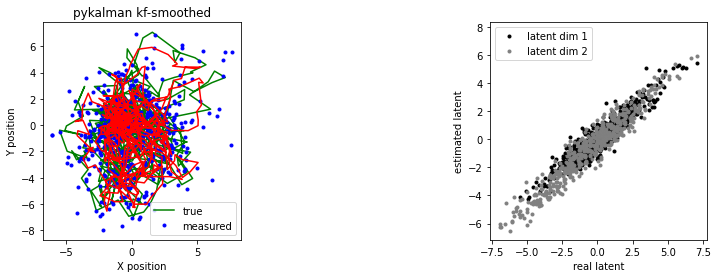

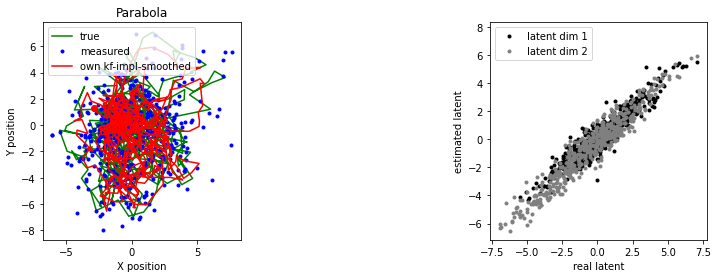

In [236]:
# compare the smooth results
smoothed_state_means, smoothed_state_covariances = kf.smooth(data)
smoothed_state_means_impl, smoothed_state_covariances_impl = my_kf.smooth(data)
_ = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], 
                smoothed_state_means[:,0], smoothed_state_means[:,1], "r-", title="pykalman kf-smoothed")
plt.axis('square');
_ = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], 
                smoothed_state_means_impl[:,0], smoothed_state_means_impl[:,1], "r-", "own kf-impl-smoothed")
plt.axis('square');

dict_keys(['transition_matrices', 'observation_matrices', 'transition_covariance', 'observation_covariance', 'transition_offsets', 'observation_offsets', 'initial_state_mean', 'initial_state_covariance', 'random_state', 'em_vars', 'n_dim_state', 'n_dim_obs'])


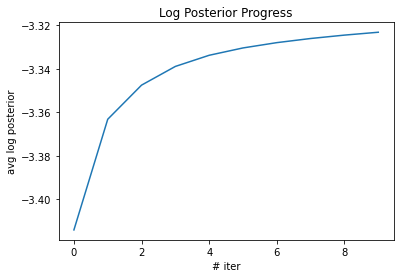

In [237]:
# visualize the change of avg log posterior
print(kf.__dict__.keys())
visualize_line_plot(my_kf.avg_em_log_posterior, "# iter", "avg log posterior", "Log Posterior Progress")

### Please turn in the code as a notebook AND as a pdf before 10/19/2021 11:55 pm. Please name your notebook netid.ipynb.

### Your work will be evaluated based on the code and plots. You don't need to write down your answers to these questions in the text blocks. 